# Interactive plots in Jupyter notebooks with matplotlib and ipywidgets
## PART I:   maximizing versatility and portability with the inline backend

## DVC 
## 01/12/2020

The whole Jupyter notebook ecosystem boasts great claims in terms of simple, powerful and interactive computing.
Nevertheless, when going beyond the most simple types of interactivity one quickly runs into problems, platform specific limitations, or complex code ... exactly what you did not hope for when choosing for the Jupyter ecosystem.

This notebook explores what is possible in terms of interactivity when restricting to the inline backend of matplotlib ... why because it is the one backend that seems to be working consistently across computing platforms, meaning standalone, Google Colab, nbviewer, .. 

## Choosing a backend for matplotlib
There are a large number of backends available.   
These fall apart in two categories:
- backends that render the plots inline in the notebook: inline, notebook, widget
- backends that render the plots outside of the notebook: qt5, tk

Which one to choose may depend on personal choice, but even more so on the computing environment and the requirements for interactivity.

### Computing environment

We consider following environments:
- standalone:   win10, maxOS
- server based: Google Colab, nbviewer

    + Google Colab: 
        - (02/12/2020) is using IPython 5.5.0 causing some serious deficiences
            + basically only supports the inline backend for matplotlib
            + it doesn't crash on the notebook or widget backends, but they don't function properly
            + misses the 'Normalization' keyword in IPython.Audio()
            + no full support of ipywidgets
        - this allows interactive plot generation (parameters settings, filenames, ... )
        - this does not comfort truly interactive plotting
    + nbviewer:
    
        
### General Guidance on Backends
- best is to set the backend BEFORE importing matplotlib.   Changing a backend en route should be supported, but is not advised and doesn't seem to work 
- when debugging code, you need to restart the kernel very often as 'things' keep on hanging around
    
### inline-like Backends for matplotlib
- what I call inline-like backends are backends that render everything inside (an output cell of) the notebook

    - **inline** (in most environments this is also the default)
        + commonly used , most robust in simple plotting, non interactive mode
        + less suited for exporting figures
        + SEVERE LIMITATION : interactive plots via REDRAW only, i.e.
            * any update requires a full redraw of a figure in the same output cell
            * but NEVER UPDATE properties of an existing figure with widget controls
            * usability depends on how heavy the compute/plot code might be 
            * there should be a way to change this setting with 
                - IPython.display.set_matplotlib_close(close=False); 
                - but it doesn't seem to solve widget interactivity
    - **notebook**
        + a variant of inline but control over the plotting canvas --> resized, exported, ..  
        + it has its own predefined output canvas for plotting
        + LIMITATIONS AND BUGS: 
            - by design you can not use the 'output' ipywidget
            - is supposed to behave unpredictable when more than one notebook is open
    - **widget** (i.e. based on ipympl)
        + matplotlib rendering is done INSIDE a jupyter OUTPUT widget
        + allowing figures + controls to be kept together in the output cell

### external backends for matplotlib
- with these backends the widgets for interactivity will be displayed inline if using ipywidgets 
- the rendering of the matplotlib plots is always in a separate window
- this independent plotting window gives the most control for postprocessing of the figures
- backends:
    - qt5: most powerful postprocessing on the plot window
    - tk: similar usage as qt5, but sometimes hanging and slow in standalone mode

###  references 
  - (dated 2018) https://medium.com/@1522933668924/using-matplotlib-in-jupyter-notebooks-comparing-methods-and-some-tips-python-c38e85b40ba1
  - tutorial on widget backend https://kapernikov.com/ipywidgets-with-matplotlib/
  - "The visualization space in the Python community is very dynamic, and I fully expect this list to be out of date as soon as it is published. Keep an eye out for what's coming in the future", Jakevdp, Python Data Science Handbook, 2016.
  - what is true for visualization is even more true for widgets

In [1]:
# execute for the widget backend -- otherwise for the inline backend, SKIP
try:
    %matplotlib widget
except:
    ! pip install iympl
    %matplotlib widget

In [2]:
%matplotlib inline

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd

In [4]:
# any of these could be useful during debugging, but not needed if all is running fine
#
#%matplotlib --list
#ipd.set_matplotlib_close(close=True)
#plt.close('all')

# 1. Updating Matplotlib Figures with interact()

In [5]:
# Method 1 : creating a new figure for each updated plot
#   This is a simple and naive approach that works well with the 'inline' backend 
#   However, as long as the created figures are not explicitly closed , they will stay in memory
#
#   All other backends will accumulate a multitude of figures unless you explicitly 
#   close the existing figure(s)
#
@interact( m=(-2.,2.), b=(-3,3,0.5))
def f(m,b):
    fig = plt.figure(figsize=(2,2))
    x = np.linspace(-10,10,num=1000)
    plt.plot(x, m*x+b )
    plt.ylim(-5,5)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [6]:
plt.close('all')

In [7]:
plt.figure(4)
plt.show()

<Figure size 432x288 with 0 Axes>

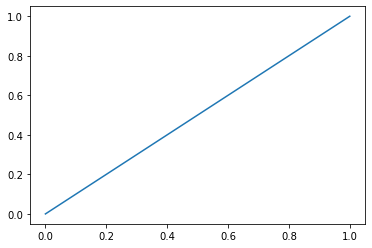

<Figure size 432x288 with 0 Axes>

In [8]:
fig1 = plt.figure(1)
fig2 = plt.figure(2)
plt.figure(1)
plt.plot([0,1])
plt.show()

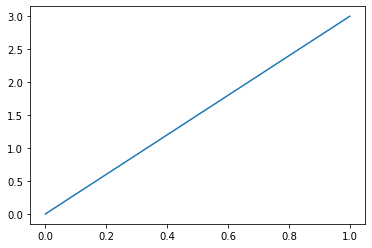

In [9]:
plt.figure(1)
plt.plot([0,3])
plt.show()

In [10]:
# Method 2 : 
#    1) create the figure 
#    2) loop
#          clear figure + plot again
# This works perfectly well with the programmatic matplotlib.pyplot interface
# work for all as long as you only use plt.xxx commands
# creating the axis explicitly and working with those does not go with 'inline'
#
# if you remove the plt.cla() differences between inline and other methods
#    is more prominent; with inline game is over after one plot; with the
#    others you keep on adding lines with each calls 
# BACKENDS: all
#
fig = plt.figure(figsize=(2,2))
x = np.linspace(-10,10,num=1000)
@interact( m=(-2.,2.), b=(-3,3,0.5))
def f(m,b):
    plt.cla()
    plt.plot(x, m*x+b )
    plt.ylim(-5,5)

<Figure size 144x144 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [11]:
# Method 3 : 
#    1) create the figure and axis
#    2) loop: 
#           clear the figure 
#           create new axis in the current figure
#           do the plotting with the OO API directly onto the axis
#
#
ax = None
x = np.linspace(-10,10,num=1000)
fig = plt.figure(figsize=(3,3))
@interact( m=(-2.,2.), b=(-3,3,0.5))
def f(m,b):
    plt.clf()
    ax = plt.axes()
    ax.plot(x, m*x+b )
    ax.set_ylim(-5,5)
    # plt.show()

<Figure size 216x216 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

## Not working with the inline backend

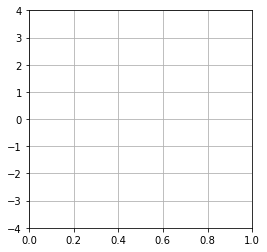

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [12]:
# Method 3a: maintain the figure and axis and just refresh the changed data
#    1) create a figure with axes
#    2) loop: remove lines on the axes and plot new lines
#         > [l.remove() for l in ax.lines]
#         > ax.plot(x, m*x+b )
#
# This cannot work with the inline backend, as control over a rendered figure is lost
# all other backends are fine with this
# 

def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
#
x = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim([-4, 4])
ax.grid(True)

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')
    #plt.show()

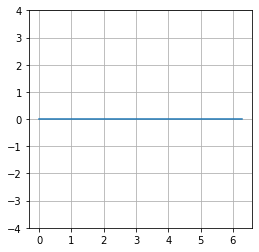

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [13]:
# Method 3b: maintain the figure and just refresh the changed data
#    1) create a figure  
#    2)  just update the y_data if you may assume that the x_data hasn't changed; 
#          between calls 
#
# BACKENDS: all, except 'inline'  
# 

def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
x = np.linspace(0, 2 * np.pi, 100)

#
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
line, = ax.plot(x, my_sine(x, 0,0,0), color='C0')

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """change the ydata values """
    line.set_ydata( my_sine(x, w, amp, phi) )
    fig.canvas.draw()
    # fig.canvas.flush_events()

In [14]:
# a simple audio signal generator
# with control for type amplitude, phase ... 
#
# the audio is immediately generated and rendered
#   continuous update are used for frequency and amplitude
#   continuous_update=False is used for the duration widget
# !! setting continuous_update is the only 'easy' control over frequency of update with interact()
# !! more complex asynchronous implementations are suggested on the ipywidgets doc pages
# !! under 'debouncing' and 'throttling' .. but this complicates the code significantly
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html?highlight=continuous_update#Continuous-updates
# !! these solutions are not applicable to interact(), but require .observe() instead, see later
#
# as the x-axis needs to be modified with the duration
#  it is more appropriate to do full redraws at every iteration
#
# BACKENDS: all
#
samplerate=8000
def generate(type='sin', freq=200.0, Fs=samplerate, Tmax=0.5):
    t = np.linspace(0.0, Tmax, int(Tmax*Fs), endpoint=False)
    if type == 'sin':
        x = np.sin(2.0*np.pi*freq*t)
    elif type == 'square':
        x = signal.square(2.0*np.pi*freq*t)
    elif type == 'sawtooth':
        x = signal.sawtooth(2.0*np.pi*freq*t)
    else:
        print( 'signal: Unrecognized signal type')
    return x, t

signal_types = [ 'sin', 'square', 'sawtooth' ]
# alternative to Dropdown is to use RadioButtons
wg_signal = widgets.Dropdown(options=signal_types,
                             value='sin',description="Signal")
wg_amp = widgets.FloatSlider(value=0.5,step=0.05,max=1.0,description='Amplitude')
wg_freq = widgets.FloatSlider(value=200.0,step=5.0,min=50.0,max=500.0,description='Frequency')
wg_Tmax = widgets.FloatSlider(value=0.4,step=0.1,min=0.1,max=2.0,description='Duration',
                             continuous_update=False)
#wg_check = widgets.Checkbox(description='Display Play Button',value=True)

fig = plt.figure(figsize=(10,4))
first_time = True

# in this example we use interact and full replotting
# this seems to work well with ALL backends
@interact(t=wg_signal,f=wg_freq,A=wg_amp,T=wg_Tmax)
def plot_fn(t,f,A,T):
    global first_time
    x1, t1 = generate(freq=f,type=t,Tmax=T)
    y1=A*x1
    plt.cla()
    plt.plot(t1,y1)
    plt.ylim(-1,1)
    ipd.display(ipd.Audio(data=y1,rate=samplerate,normalize=False, autoplay=True))
    return

<Figure size 720x288 with 0 Axes>

interactive(children=(Dropdown(description='Signal', options=('sin', 'square', 'sawtooth'), value='sin'), Floa…

# 2. Using observe() and callbacks for more control over the interaction
## The Output Widget, Widget Boxes, Observers, Classes, ... and fragile backends

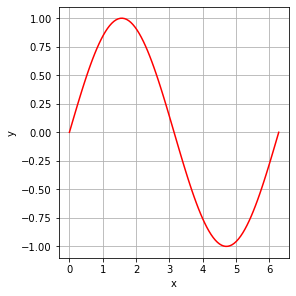

In [15]:
# create some x data and plot it in the output widget
# give control over data, axis, .. via control widgets using callbacks
#
x = np.linspace(0, 2 * np.pi, 100)
output = widgets.Output() 
with output:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
# move the toolbar to the bottom
fig.canvas.toolbar_position = 'bottom'
ax.grid(True)    
line, = ax.plot(x, np.sin(x), '#FF0000')

# create some control elements
int_slider = widgets.IntSlider(value=1, min=0, max=10, step=1, description='freq')
color_picker = widgets.ColorPicker(value='#FF0000', description='pick a color')
text_xlabel = widgets.Text(value='', description='xlabel', continuous_update=False)
text_ylabel = widgets.Text(value='', description='ylabel', continuous_update=False)
 
# callback functions
def update(change):
    """redraw line (update plot)"""
    line.set_ydata(np.sin(change.new * x))
    fig.canvas.draw()
     
def line_color(change):
    """set line color"""
    line.set_color(change.new)
     
def update_xlabel(change):
    ax.set_xlabel(change.new)
     
def update_ylabel(change):
    ax.set_ylabel(change.new)
 
# connect callbacks and traits
int_slider.observe(update, 'value')
color_picker.observe(line_color, 'value')
text_xlabel.observe(update_xlabel, 'value')
text_ylabel.observe(update_ylabel, 'value')
 
text_xlabel.value = 'x'
text_ylabel.value = 'y'
controls = widgets.VBox([int_slider, color_picker, text_xlabel, text_ylabel])
widgets.HBox([controls, output])

## Packing components in a class

This is a copy from the Kapernikov tutorial

To create more high level components, we can also subclass a container and build up our gui from within. Containers have a `children` property to which we can assign a list of widgets that should be displayed. Although, we can assign a list, this is turned into a tuple and cannot be modified afterwards.
To remove or add a widget at runtime, the children tuple can be turned back into a list, followed by an insert or deletion and finalised by reassigning to the children property. Since it can be easy to make mistakes when going by index, I tend to add a placeholder box in which I only place the 'dynamic' widget.

The example below, packs the entire oscilliscope 'dashboard' in a single component by subclassing `VBox`. All the required widgets are defined in the Sines class and added as its `children`. The callbacks are defined as instance methods. It may not be a masterpiece in object oriented programming, but hopefully it shows the idea of constructing larger reusable components. Note that, we need to call `super().__init__()` from `__init__` to properly initialise the parent class. 

Sines(children=(VBox(children=(IntSlider(value=1, description='freq', max=10), ColorPicker(value='#FF00DD', de…

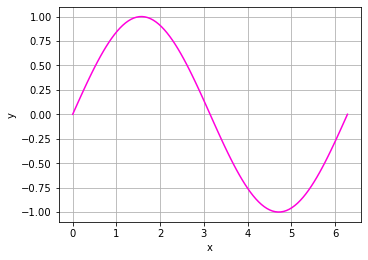

In [16]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class Sines(widgets.HBox):
    
    def __init__(self):
        super().__init__()
        output = widgets.Output()

        self.x = np.linspace(0, 2 * np.pi, 100)
        initial_color = '#FF00DD'

        with output:
            self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(5, 3.5))
        self.line, = self.ax.plot(self.x, np.sin(self.x), initial_color)
        
        self.fig.canvas.toolbar_position = 'bottom'
        self.ax.grid(True)

        # define widgets
        int_slider = widgets.IntSlider(
            value=1, 
            min=0, 
            max=10, 
            step=1, 
            description='freq'
        )
        color_picker = widgets.ColorPicker(
            value=initial_color, 
            description='pick a color'
        )
        text_xlabel = widgets.Text(
            value='', 
            description='xlabel', 
            continuous_update=False
        )
        text_ylabel = widgets.Text(
            value='', 
            description='ylabel', 
            continuous_update=False
        )

        controls = widgets.VBox([
            int_slider, 
            color_picker, 
            text_xlabel, 
            text_ylabel
        ])
        controls.layout = make_box_layout()
        
        out_box = widgets.Box([output])
        output.layout = make_box_layout()

        # observe stuff
        int_slider.observe(self.update, 'value')
        color_picker.observe(self.line_color, 'value')
        text_xlabel.observe(self.update_xlabel, 'value')
        text_ylabel.observe(self.update_ylabel, 'value')
        
        text_xlabel.value = 'x'
        text_ylabel.value = 'y'
        

        # add to children
        self.children = [controls, output]
    
    def update(self, change):
        """Draw line in plot"""
        self.line.set_ydata(np.sin(change.new * self.x))
        self.fig.canvas.draw()

    def line_color(self, change):
        self.line.set_color(change.new)

    def update_xlabel(self, change):
        self.ax.set_xlabel(change.new)

    def update_ylabel(self, change):
        self.ax.set_ylabel(change.new)
        
        
Sines()